# Otimização de Arquitetura de Redes Neurais com Algoritmos Genéticos 

## Teste 02: Dataset CIFAR-10

### 01. Importação de Bibliotecas

In [1]:
# Importação de Bibliotecas
import time
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from deap import base, creator, tools, algorithms
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### 02. Separação do Dataset

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Dividindo o trainset em treino e validação
val_size = int(0.1 * len(trainset))
train_size = len(trainset) - val_size
trainset, validset = random_split(trainset, [train_size, val_size])

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
validloader = DataLoader(validset, batch_size=64, shuffle=False)
testloader = DataLoader(testset, batch_size=100, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


### 03. Arquitetura inicial da Rede Neural

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleNet(nn.Module):
    def __init__(self, n_neurons, activation_fn):
        super(SimpleNet, self).__init__()
        # Primeira camada convolucional: 3 canais de entrada (CIFAR-10), 32 canais de saída, kernel 3x3
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        # Segunda camada convolucional: 32 canais de entrada, 64 de saída, kernel 3x3
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # Terceira camada convolucional: 64 canais de entrada, 128 de saída, kernel 3x3
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        # Camada totalmente conectada
        self.fc1 = nn.Linear(128 * 4 * 4, n_neurons)
        self.activation = activation_fn
        self.fc2 = nn.Linear(n_neurons, 10)  # CIFAR-10 tem 10 classes

    def forward(self, x):
        # Primeira camada convolucional seguida de ReLU e MaxPooling
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        # Segunda camada convolucional seguida de ReLU e MaxPooling
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        # Terceira camada convolucional seguida de ReLU e MaxPooling
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        # Achatar a saída para a camada totalmente conectada
        x = x.view(-1, 128 * 4 * 4)
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x


### 04. Função de treinamento e avaliação do Modelo

In [4]:
# Função de treinamento e avaliação
def train_and_evaluate(model, trainloader, testloader, criterion, optimizer, num_epochs=10):
    start_time = time.time()
    train_losses = []
    
    for epoch in tqdm(range(num_epochs), desc='Treinamento', unit='época'):
        running_loss = 0.0
        for inputs, labels in tqdm(trainloader, desc='Batchs', leave=False, unit='batch'):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(trainloader)
        train_losses.append(avg_loss)
        print(f"Época {epoch + 1}, Loss: {avg_loss:.4f}")
    
    total = 0
    correct = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(testloader, desc='Avaliação', unit='batch'):
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = correct / total
    time_taken = time.time() - start_time
    cm = confusion_matrix(all_labels, all_preds)
    return accuracy, train_losses, time_taken, cm

### 05. Algoritmo Genético

In [5]:
# Função de avaliação do indivíduo
def evaluate_individual(individual):
    n_neurons, activation_idx, learning_rate, batch_size = individual

    # Certifique-se de que activation_idx esteja dentro do intervalo esperado
    activation_idx = min(max(activation_idx, 0), 1)
    activation_fn = [nn.ReLU(), nn.Sigmoid()][activation_idx]
    
    model = SimpleNet(n_neurons, activation_fn)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    # Treinamento no conjunto de treinamento
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
    for epoch in range(3):  # Treinando por 3 épocas como exemplo
        for inputs, labels in trainloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Avaliação no conjunto de validação
    validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=False)
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in validloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy,

In [6]:
# Configuração do Algoritmo Genético
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_int", random.randint, 10, 200)  # Número de neurônios
toolbox.register("attr_activation", random.randint, 0, 1)  # Função de ativação (ReLU ou Sigmoid)
toolbox.register("attr_float", random.uniform, 0.001, 0.1)  # Taxa de aprendizado
toolbox.register("attr_batch", random.randint, 32, 128)  # Tamanho do batch

toolbox.register("individual", tools.initCycle, creator.Individual, 
                 (toolbox.attr_int, toolbox.attr_activation, toolbox.attr_float, toolbox.attr_batch), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate_individual)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=10, up=200, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Algoritmo Genético
population = toolbox.population(n=10)
NGEN = 5
for gen in tqdm(range(NGEN), desc='Gerações'):
    offspring = algorithms.varAnd(population, toolbox, cxpb=0.5, mutpb=0.2)
    
    fits = list(tqdm(map(toolbox.evaluate, offspring), total=len(offspring), desc="Avaliando Indivíduos"))
    
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    population = toolbox.select(offspring, k=len(population))

# Seleciona o melhor indivíduo
top_ind = tools.selBest(population, k=1)[0]

# Parâmetros do melhor indivíduo
best_params = {
    'n_neurons': top_ind[0],
    'activation_idx': top_ind[1],
    'learning_rate': top_ind[2],
    'batch_size': top_ind[3]
}

Gerações: 100%|███████████████████████████████████████████████████████████████████████| 5/5 [3:46:18<00:00, 2715.65s/it]


In [7]:
print("Melhor indivíduo:", top_ind)
print("Parâmetros:", best_params)

Melhor indivíduo: [174, 126, 0.0911517630847065, 17]
Parâmetros: {'n_neurons': 174, 'activation_idx': 126, 'learning_rate': 0.0911517630847065, 'batch_size': 17}


### 06. Treinamento dos Modelos

#### Modelo Não Otimizado 1

In [8]:
# Modelo Não Otimizado
model_non_opt_1 = SimpleNet(n_neurons=50, activation_fn=nn.Sigmoid())
criterion_1 = nn.CrossEntropyLoss()
optimizer_1 = optim.SGD(model_non_opt_1.parameters(), lr=0.01)

accuracy_non_opt_1, train_losses_non_opt_1, time_non_opt_1, cm_non_opt_1 = train_and_evaluate(model_non_opt_1, trainloader, testloader, criterion_1, optimizer_1)

Treinamento:  10%|██████▋                                                            | 1/10 [01:51<16:45, 111.70s/época]

Época 1, Loss: 2.3054



Treinamento:  20%|█████████████▍                                                     | 2/10 [03:38<14:29, 108.66s/época]

Época 2, Loss: 2.2956



Treinamento:  30%|████████████████████                                               | 3/10 [05:27<12:43, 109.11s/época]

Época 3, Loss: 2.2454



Treinamento:  40%|██████████████████████████▊                                        | 4/10 [07:22<11:06, 111.10s/época]

Época 4, Loss: 2.0833



Treinamento:  50%|█████████████████████████████████▌                                 | 5/10 [09:25<09:38, 115.68s/época]

Época 5, Loss: 1.9497



Treinamento:  60%|████████████████████████████████████████▏                          | 6/10 [11:38<08:06, 121.55s/época]

Época 6, Loss: 1.8487



Treinamento:  70%|██████████████████████████████████████████████▉                    | 7/10 [13:48<06:12, 124.28s/época]

Época 7, Loss: 1.7582



Treinamento:  80%|█████████████████████████████████████████████████████▌             | 8/10 [15:57<04:11, 125.68s/época]

Época 8, Loss: 1.6767



Treinamento:  90%|████████████████████████████████████████████████████████████▎      | 9/10 [18:12<02:08, 128.65s/época]

Época 9, Loss: 1.6123



Treinamento: 100%|██████████████████████████████████████████████████████████████████| 10/10 [20:10<00:00, 121.08s/época]


Época 10, Loss: 1.5638


Avaliação: 100%|███████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.62batch/s]


#### Modelo Não Otimizado 2

In [9]:
# Modelo Não Otimizado
model_non_opt_2 = SimpleNet(n_neurons=200, activation_fn=nn.ReLU())
criterion_2 = nn.CrossEntropyLoss()
optimizer_2 = optim.SGD(model_non_opt_2.parameters(), lr=0.05)

accuracy_non_opt_2, train_losses_non_opt_2, time_non_opt_2, cm_non_opt_2 = train_and_evaluate(model_non_opt_2, trainloader, testloader, criterion_2, optimizer_2)

Treinamento:  10%|██████▋                                                            | 1/10 [02:03<18:35, 123.95s/época]

Época 1, Loss: 1.9005



Treinamento:  20%|█████████████▍                                                     | 2/10 [04:05<16:18, 122.37s/época]

Época 2, Loss: 1.4211



Treinamento:  30%|████████████████████                                               | 3/10 [06:39<15:57, 136.72s/época]

Época 3, Loss: 1.1836



Treinamento:  40%|██████████████████████████▊                                        | 4/10 [08:58<13:45, 137.66s/época]

Época 4, Loss: 1.0171



Treinamento:  50%|█████████████████████████████████▌                                 | 5/10 [11:23<11:42, 140.42s/época]

Época 5, Loss: 0.8918



Treinamento:  60%|████████████████████████████████████████▏                          | 6/10 [13:44<09:22, 140.53s/época]

Época 6, Loss: 0.7889



Treinamento:  70%|██████████████████████████████████████████████▉                    | 7/10 [16:13<07:09, 143.30s/época]

Época 7, Loss: 0.6970



Treinamento:  80%|█████████████████████████████████████████████████████▌             | 8/10 [18:29<04:41, 140.95s/época]

Época 8, Loss: 0.6147



Treinamento:  90%|████████████████████████████████████████████████████████████▎      | 9/10 [20:26<02:13, 133.63s/época]

Época 9, Loss: 0.5443



Treinamento: 100%|██████████████████████████████████████████████████████████████████| 10/10 [22:06<00:00, 132.68s/época]


Época 10, Loss: 0.4696


Avaliação: 100%|███████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  9.08batch/s]


#### Modelo Não Otimizado 3

In [10]:
# Modelo Não Otimizado
model_non_opt_3 = SimpleNet(n_neurons=100, activation_fn=nn.ReLU())
criterion_3 = nn.CrossEntropyLoss()
optimizer_3 = optim.SGD(model_non_opt_3.parameters(), lr=0.01)

accuracy_non_opt_3, train_losses_non_opt_3, time_non_opt_3, cm_non_opt_3 = train_and_evaluate(model_non_opt_3, trainloader, testloader, criterion_3, optimizer_3)

Treinamento:  10%|██████▊                                                             | 1/10 [01:38<14:47, 98.63s/época]

Época 1, Loss: 2.2121



Treinamento:  20%|█████████████▌                                                      | 2/10 [03:16<13:06, 98.34s/época]

Época 2, Loss: 1.8949



Treinamento:  30%|████████████████████▍                                               | 3/10 [04:55<11:31, 98.73s/época]

Época 3, Loss: 1.6678



Treinamento:  40%|███████████████████████████▏                                        | 4/10 [06:33<09:50, 98.35s/época]

Época 4, Loss: 1.5265



Treinamento:  50%|██████████████████████████████████                                  | 5/10 [08:13<08:15, 99.02s/época]

Época 5, Loss: 1.4369



Treinamento:  60%|████████████████████████████████████████▊                           | 6/10 [09:46<06:26, 96.66s/época]

Época 6, Loss: 1.3609



Treinamento:  70%|███████████████████████████████████████████████▌                    | 7/10 [11:15<04:42, 94.33s/época]

Época 7, Loss: 1.2943



Treinamento:  80%|██████████████████████████████████████████████████████▍             | 8/10 [12:44<03:05, 92.76s/época]

Época 8, Loss: 1.2205



Treinamento:  90%|█████████████████████████████████████████████████████████████▏      | 9/10 [14:19<01:33, 93.44s/época]

Época 9, Loss: 1.1654



Treinamento: 100%|███████████████████████████████████████████████████████████████████| 10/10 [15:52<00:00, 95.21s/época]


Época 10, Loss: 1.1095


Avaliação: 100%|███████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.50batch/s]


#### Modelo Otimizado

In [13]:
# Modelo Otimizado
#activation_fn = [nn.ReLU(), nn.Sigmoid()][best_params['activation_idx']]
model_opt = SimpleNet(best_params['n_neurons'], activation_fn=nn.ReLU())
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_opt.parameters(), lr=best_params['learning_rate'])

accuracy_opt, train_losses_opt, time_opt, cm_opt = train_and_evaluate(model_opt, trainloader, testloader, criterion, optimizer)

Treinamento:  10%|██████▊                                                             | 1/10 [01:27<13:07, 87.46s/época]

Época 1, Loss: 1.7843



Treinamento:  20%|█████████████▌                                                      | 2/10 [02:53<11:34, 86.85s/época]

Época 2, Loss: 1.2976



Treinamento:  30%|████████████████████▍                                               | 3/10 [04:20<10:06, 86.60s/época]

Época 3, Loss: 1.0533



Treinamento:  40%|███████████████████████████▏                                        | 4/10 [05:47<08:40, 86.70s/época]

Época 4, Loss: 0.8805



Treinamento:  50%|██████████████████████████████████                                  | 5/10 [07:13<07:13, 86.63s/época]

Época 5, Loss: 0.7532



Treinamento:  60%|████████████████████████████████████████▊                           | 6/10 [08:45<05:54, 88.57s/época]

Época 6, Loss: 0.6449



Treinamento:  70%|███████████████████████████████████████████████▌                    | 7/10 [10:18<04:29, 89.85s/época]

Época 7, Loss: 0.5475



Treinamento:  80%|██████████████████████████████████████████████████████▍             | 8/10 [11:50<03:01, 90.64s/época]

Época 8, Loss: 0.4512



Treinamento:  90%|█████████████████████████████████████████████████████████████▏      | 9/10 [13:24<01:31, 91.48s/época]

Época 9, Loss: 0.3709



Treinamento: 100%|███████████████████████████████████████████████████████████████████| 10/10 [14:55<00:00, 89.59s/época]


Época 10, Loss: 0.2929


Avaliação: 100%|███████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.76batch/s]


### 07. Avaliação dos Modelos

In [14]:
# Comparação dos Resultados
print(f"Modelo Não Otimizado 1: Acurácia = {accuracy_non_opt_1:.4f}, Loss = {train_losses_non_opt_1[-1]:.4f}, Tempo = {time_non_opt_1:.2f}s")
print(f"Modelo Não Otimizado 2: Acurácia = {accuracy_non_opt_2:.4f}, Loss = {train_losses_non_opt_2[-1]:.4f}, Tempo = {time_non_opt_2:.2f}s")
print(f"Modelo Não Otimizado 3: Acurácia = {accuracy_non_opt_3:.4f}, Loss = {train_losses_non_opt_3[-1]:.4f}, Tempo = {time_non_opt_3:.2f}s")
print(f"Modelo Otimizado: Acurácia = {accuracy_opt:.4f}, Loss = {train_losses_opt[-1]:.4f}, Tempo = {time_opt:.2f}s")

Modelo Não Otimizado 1: Acurácia = 0.4367, Loss = 1.5638, Tempo = 1223.99s
Modelo Não Otimizado 2: Acurácia = 0.7010, Loss = 0.4696, Tempo = 1337.79s
Modelo Não Otimizado 3: Acurácia = 0.5828, Loss = 1.1095, Tempo = 961.61s
Modelo Otimizado: Acurácia = 0.7114, Loss = 0.2929, Tempo = 905.20s


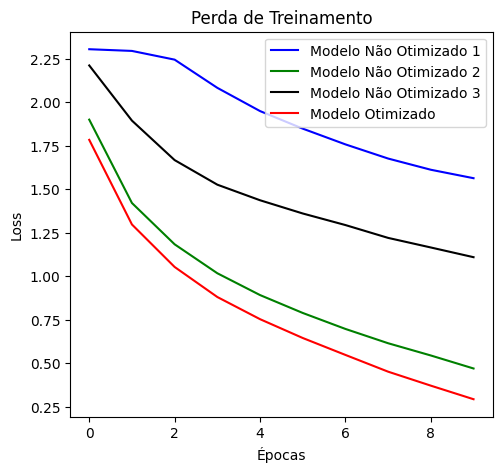

In [15]:
# Plotando gráficos comparativos
plt.figure(figsize=(12, 5))

# Gráfico da perda de treinamento
plt.subplot(1, 2, 1)
plt.plot(train_losses_non_opt_1, label='Modelo Não Otimizado 1', color='blue')
plt.plot(train_losses_non_opt_2, label='Modelo Não Otimizado 2', color='green')
plt.plot(train_losses_non_opt_3, label='Modelo Não Otimizado 3', color='black')
plt.plot(train_losses_opt, label='Modelo Otimizado', color='red')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title('Perda de Treinamento')
plt.legend()

In [ ]:
# Gráfico de comparação de acurácia e tempo de treinamento
plt.subplot(1, 2, 2)
bar_width = 0.35
index = range(2)
bar1 = plt.bar(index, [accuracy_non_opt, accuracy_opt], bar_width, label='Acurácia')
bar2 = plt.bar([i + bar_width for i in index], [time_non_opt, time_opt], bar_width, label='Tempo (s)')
plt.xlabel('Modelo')
plt.ylabel('Valor')
plt.title('Comparação de Modelos')
plt.xticks([i + bar_width / 2 for i in index], ['Não Otimizado', 'Otimizado'])
plt.legend()

plt.tight_layout()
plt.show()

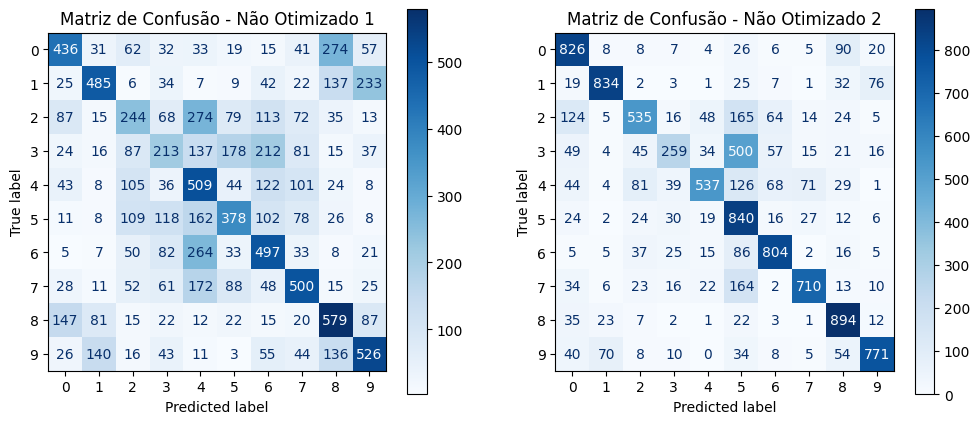

In [16]:
# Plotando a Matriz de Confusão
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Matriz de Confusão - Modelo Não Otimizado 1
disp_non_opt_1 = ConfusionMatrixDisplay(confusion_matrix=cm_non_opt_1, display_labels=range(10))
disp_non_opt_1.plot(ax=ax[0], cmap=plt.cm.Blues, values_format='d')
ax[0].set_title('Matriz de Confusão - Não Otimizado 1')

# Matriz de Confusão - Modelo Não Otimizado 2
disp_non_opt_2 = ConfusionMatrixDisplay(confusion_matrix=cm_non_opt_2, display_labels=range(10))
disp_non_opt_2.plot(ax=ax[1], cmap=plt.cm.Blues, values_format='d')
ax[1].set_title('Matriz de Confusão - Não Otimizado 2')

plt.show()

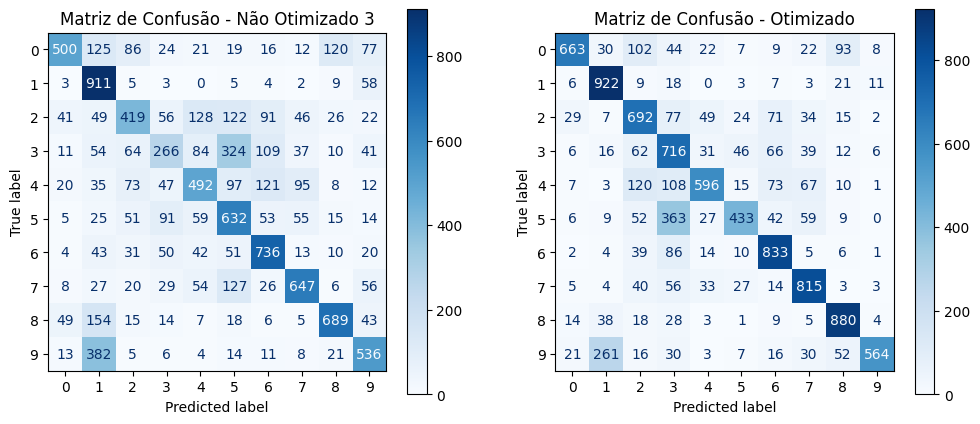

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Matriz de Confusão - Modelo Não Otimizado 3
disp_non_opt_3 = ConfusionMatrixDisplay(confusion_matrix=cm_non_opt_3, display_labels=range(10))
disp_non_opt_3.plot(ax=ax[0], cmap=plt.cm.Blues, values_format='d')
ax[0].set_title('Matriz de Confusão - Não Otimizado 3')

# Matriz de Confusão - Modelo Otimizado
disp_opt = ConfusionMatrixDisplay(confusion_matrix=cm_opt, display_labels=range(10))
disp_opt.plot(ax=ax[1], cmap=plt.cm.Blues, values_format='d')
ax[1].set_title('Matriz de Confusão - Otimizado')

plt.show()